# Hand Written Digit Recognition with ANN using Pytorch

### Author: Ahmed Hamza Bin Asif

#### Language: Python
#### Framework: Pytorch
#### Libraries: Numpy, Matplotlib
#### CPU: AMD Ryzen 5 3600
#### GPU: Nvidia GTX 1660 Super


### Step 0: Import Required Libraries

In [1]:
import os
import numpy as np
import torch
import torchvision
from torchvision import transforms
import torch.nn as nn
import torch.nn.functional as F 
import matplotlib.pyplot as plt 

### Step 1: Data Transformation

In [2]:
# transform.ToTensor() to convert images into numbers and seperate the images into three(red, green, blue) channels
# transform.Normalise() to normalise the dataset along its mean and standard deviation
# torchvision.transforms.compose() to convert the output of above two functions into torch tensors

transform = torchvision.transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5), (0.5)),])

### Step 2: Data Collection

In [3]:
# download the dataset using torchvision.datasets.MNIST() into train and test sets
# apply the transformations to the data

trainSet = torchvision.datasets.MNIST('data', train = True, download = True, transform = transform)
testSet = torchvision.datasets.MNIST('data', train = False, download = True, transform = transform)

### Step 3: Data Loading

In [4]:
# Load the dataset into train and test set using Pytorch Dataloader
# Set the batch size to 128 for better performance
# Shuffle the dataset so that the data doesn't depend on the order
# train and test loader will be torch tensors that will contain the Image and its Label

trainLoader = torch.utils.data.DataLoader(trainSet, batch_size = 128, shuffle = True)
testLoader = torch.utils.data.DataLoader(testSet, batch_size = 128, shuffle = True)

### Step 4: Data Visulaization

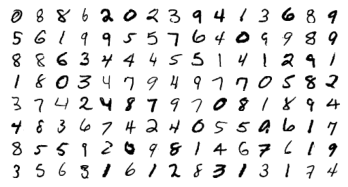

In [5]:
# iter() to create an iterator object. The object will be the training set.
# next() will be used on the iter() object to get iterate through the pictures
# img will contain the image and lbl will contain the label for that image
# use matplotlib functions to create a plot to display 120 images
# numpy.squeeze() to remove unnecessary one-dimensional entries

img, lbl = next(iter(trainLoader))
#print(type(img))
#print(type(lbl))
fig = plt.figure()
n_img = 120
for i in range(1, n_img + 1):
    plt.subplot(10, 15, i)
    plt.axis('off')
    plt.imshow(img[i].numpy().squeeze(), cmap='gray_r')

### Step 5: NeuralNet Building

In [6]:
# Create a class to define the building blocks of the neural network
# super(Net, self).__init__() will be used to inherit the nn module class and its functions
# The neural network will comprise of 1 Input layer, 2 Hidden layers, 1 Output layer
# First two Linear layers will use Relu as their Activation functions
# Purpose of using Relu instead of Sigmoid is that Relu is computationaly more efficent and converge better
# First two Linear layers will also use the drop out function as a Regularization method
# Purpose of using the dropout function is that neural nets when trained on small datasets tend to overfit which leads to
# poor performance in testing phase so drop outs are used to randomly turn off some neurons in the hidden layers of the net
# In the end the output will be applied the Softmax function
# Purpose of using Log Softmax is for three reasons:
# First Reason is that this is a multiclass classification problem in which log softmax works best
# Second Reason is that it will convert the output of the net into log probability distributions so that argmax can be used
# later to get the maximum probability
# Third Reason is that log softmax combined with the negative log likelihood will act as our Cross Entropy loss Functon.

class Net(nn.Module):
    # Constructor
    def __init__(self, in_size, n_hidden, out_size, p = 0.5):
        super(Net, self).__init__()
        self.drop = nn.Dropout(p=p)
        self.linear1 = nn.Linear(in_size, n_hidden)
        self.linear2 = nn.Linear(n_hidden, n_hidden)
        self.linear3 = nn.Linear(n_hidden, out_size)
    
    # Prediction function
    def forward(self, x):
        x = x.view(-1, 28 * 28)
        x = F.relu(self.drop(self.linear1(x)))
        x = F.relu(self.drop(self.linear2(x)))
        x = self.linear3(x)
        x = F.log_softmax(x)
        return x

In [7]:
# This part will initialize the above neural network
# Size of input layer wil be 784 becuase each image in the dataset have a dimension of 24 * 24 pixels
# The number of hidden units will be 396 in both layers
# Size of output layer will be 10 to get 10 neurons as an output

# Initializer
input_size = 784
hidden_size = 396
output_size = 10

model = Net(input_size, hidden_size, output_size)

### Step 6 : Hyperparameters

In [8]:
# The dataset will be iterated through 15 times during model training in order to get better performance so Epoch will be 15
# Batch size will be 128
# Learning rate is the rate at which our Model will perform Gradient Descent to converge to the Global Minimum
# torch.optim.SGD - Stochastic Gradient Descent will be used as the Optimizer of this model
# Momentum will also be used with SGD to accelerate the SGD towards the global minimum
# Loss Function is not defined in this section becuase that will be defined later in the training section

epochs = 15
batch_size = 128
learning_rate = 0.01
momentum = 0.9

optimizer = torch.optim.SGD(model.parameters(),lr=learning_rate, momentum=momentum)

### Step 7: Model Training

In [9]:
# import tqdm library to give the model trainig a clean look
# model train function will take neural network model, training set, optimizer function and number of epoch as input parameters
# Model.train() will be called from nn Module to train the model
# Python enumerate() function will be used to add a counter to the training set images
# In every iteration of the loop the following steps will be performed: 
# 1. One image and its label will be taken from the training set and sent to the Neural Net which will later gets processed
# 2. The optimizer function will set the gradients to zero after every iteration so that the gradient descent will start from
# zero after every iteration
# 3. Torch Negative Log Likelihood Loss function will take the log softmax output(Predicted label) of the model and the 
# correct label and calculate the loss if the model predicted didn't predict accurately.
# 4. loss.backward() will be used to compute the gradient loss and Backpropagation to update the parameters of the activation
# functions. This is the most important part of the neural network
# After every epoch, model loss will be shown.

from tqdm import tqdm
def modelTrain(model, trainLoader, optimizer, epoch):
    model.train()
    pbar = tqdm(trainLoader)
    for batch_idx, (data, target) in enumerate(pbar):
        optimizer.zero_grad()
        output = model(data)
        loss = F.nll_loss(output, target)
        loss.backward()
        optimizer.step()
        pbar.set_description(desc= f'epoch: {epoch} loss={loss.item()}')

In [10]:
# Train the model for 15 epochs

for epoch in range(1, epochs+1):
    modelTrain(model, trainLoader, optimizer, epoch)

  0%|                                                                                          | 0/469 [00:00<?, ?it/s]<ipython-input-6-883a9093b780>:31: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  x = F.log_softmax(x)
epoch: 15 loss=0.07889793068170547: 100%|████████████████████████████████████████████| 469/469 [00:10<00:00, 45.55it/s]


### Step 8: Model Testing

In [11]:
# modeltest() function will take the neural net
# model.eval() will be called from nn.module for model evaluation
# Two variables will be initialized to calculate the loss and accuracy for the test set 
# Following steps will be performed during model testing:
# 1. Gradient will be initialized to zero
# 2. In every iteration of the test data, one image and its label will taken for testing
# 3. Image will be given to the learned model for testing
# 4. Negative Log Likelihood Loss function will be used to compute the loss for the image
# 5. np.argmax() will be used to get the indices of the maximum probability tensor
# 6. Model accuracy will be calculated after summing up the tensor values and getting the element-wise equality using
# pytorch.eq() function
# 7. After complete testing the Average loss will be calculated by dividing the total loss with total number of images 
# in the dataset.
# Average Loss and model accuracy will be shown as the final output for the function

def modelTest(model, testLoader):
    #model = Net()
    #model.load_state_dict(torch.load(PATH))
    model.eval()
    testLoss = 0
    accurate = 0
    with torch.no_grad():
        for data, target in testLoader:
            output = model(data)
            #print(type(output))
            testLoss += F.nll_loss(output, target).item()
            #print(type(testLoss))
            predict = output.argmax(dim = 1, keepdim = True)
            #print(type(predict))
            accurate += predict.eq(target.view_as(predict)).sum().item()
            #print(type(accurate))
            
    testLoss /= len(testLoader.dataset)
    
    print('\nTest set') 
    print("Images Tested: {}".format(len(testLoader.dataset)))
    print('Average loss: {:.4f} \nAccuracy: {}/{} => ({:.1f}%)\n'.format(
        testLoss, accurate, len(testLoader.dataset),
        100 * (accurate / len(testLoader.dataset))))

In [12]:
modelTest(model, testLoader)

<ipython-input-6-883a9093b780>:31: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  x = F.log_softmax(x)



Test set
Images Tested: 10000
Average loss: 0.0006 
Accuracy: 9778/10000 => (97.8%)



### Step 9: Model Prediction

In [13]:
# In this stage the model will predict the label(number) with maximum probability
# All the images are in Tensor format so first they will be converted into numpy format and furthur the outputs will
# use np.squeeze to remove one-dimensional entries
# To do that var.data.numpy().squeeze() will be used
# The target label will be shown on the left
# A graph for probablities from 0.0 - 1.0 for 0-9 numbers will be generated on the right
# next(iter(testlodaer)) will be used to get images and an iterator from the testset
# The image will be converted to a Tensor and given to the Model for prediction
# Neural Net will give the log probabilities as an output in a Tensor format
# The Tensor will be converted into numpy format and then into a list
# Get the index with the maximum probability from the list. The index number will be the predicted Digit

def predictDigit(img, ps):
    tensorToNP = ps.data.numpy().squeeze()
    #plt.subplots will be used to plot two plots side by side
    fig, (ax1, ax2) = plt.subplots(figsize=(6,6), ncols=2)
    #images will be resized into 28*28 pixels into its original form
    ax1.imshow(img.resize(28, 28).numpy().squeeze())
    #axis will be off to remove number outlines from image plot
    ax1.axis('off')
    #horizontal barchart will be generated for max probability of a number
    ax2.barh(np.arange(10), tensorToNP)
    ax2.set_aspect(0.1)
    #10 numbers will be plotted on the y-axis of the barh
    ax2.set_yticks(np.arange(10))
    ax2.set_yticklabels(np.arange(10))
    ax2.set_title('Maximum Digit Probability')
    #Limits for x-axis numbers will be from 0 - 1.0
    ax2.set_xlim(0, 1.05)

[1.2795676e-09, 5.7702437e-11, 1.4940078e-08, 1.7221459e-12, 3.181005e-09, 4.083136e-09, 1.0, 2.7025391e-12, 2.1216176e-10, 1.2454468e-14]
Predicted Digit = 6


<ipython-input-6-883a9093b780>:31: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  x = F.log_softmax(x)


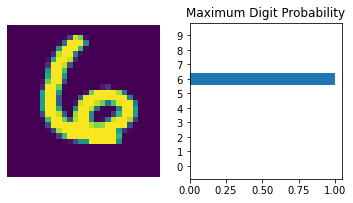

In [19]:
img, lbl = next(iter(testLoader))

img = img[0].view(1, 784)
with torch.no_grad():
    numProb = model(img)

ps = torch.exp(numProb)
probab = list(ps.numpy()[0])
print(probab)
print("Predicted Digit =", probab.index(max(probab)))
predictDigit(img, ps)


### Step 10: Save Model

In [15]:
PATH = os.getcwd()
torch.save(model.state_dict(), os.path.join(PATH,"ModelCPU.pt"))

### References:
#### https://medium.com/@ankitbatra2202/mnist-handwritten-digit-recognition-with-pytorch-cce6a33cd1c1
#### https://medium.com/@ravivaishnav20/handwritten-digit-recognition-using-pytorch-get-99-5-accuracy-in-20-k-parameters-bcb0a2bdfa09
#### https://towardsdatascience.com/handwritten-digit-mnist-pytorch-977b5338e627
#### https://github.com/yrowe/Digit-Recognizer-with-pytorch/blob/master/digit_recognizer.ipynb
#### https://www.pluralsight.com/guides/building-your-first-pytorch-solution